In [1]:
from io import open
import glob
import os


def findFiles(path):
    return glob.glob(path)


print(findFiles("../data/names/*.txt"))

['../data/names/Czech.txt', '../data/names/German.txt', '../data/names/Arabic.txt', '../data/names/Japanese.txt', '../data/names/Chinese.txt', '../data/names/Vietnamese.txt', '../data/names/Russian.txt', '../data/names/French.txt', '../data/names/Irish.txt', '../data/names/English.txt', '../data/names/Spanish.txt', '../data/names/Greek.txt', '../data/names/Italian.txt', '../data/names/Portuguese.txt', '../data/names/Scottish.txt', '../data/names/Dutch.txt', '../data/names/Korean.txt', '../data/names/Polish.txt']


In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(f"{all_letters=};\n{n_letters=}")

all_letters="abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'";
n_letters=57


In [3]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return "".join(
        c
        for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn" and c in all_letters
    )


print(unicodeToAscii("Ślusàrski"))

Slusarski


In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []


# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding="utf-8").read().strip().split("\n")
    return [unicodeToAscii(line) for line in lines]


for filename in findFiles("../data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    print(f"{category=}")
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(f"{n_categories=}")

category='Czech'
category='German'
category='Arabic'
category='Japanese'
category='Chinese'
category='Vietnamese'
category='Russian'
category='French'
category='Irish'
category='English'
category='Spanish'
category='Greek'
category='Italian'
category='Portuguese'
category='Scottish'
category='Dutch'
category='Korean'
category='Polish'
n_categories=18


In [5]:
print(category_lines["Italian"][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [6]:
import torch


# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)


# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor


# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


print(letterToTensor("J"))

print(lineToTensor("Jones").size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [7]:
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print(f"{n_letters=}; {n_hidden=}; {n_categories=}")

n_letters=57; n_hidden=128; n_categories=18


In [8]:
input = letterToTensor("A")
print(f"{input.size()=}; {input=}")

hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(f"{output.size()=}; {output=}")
print(f"{next_hidden.size()=}; {next_hidden=}")

input.size()=torch.Size([1, 57]); input=tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
output.size()=torch.Size([1, 18]); output=tensor([[-2.9768, -2.9442, -2.9659, -2.8805, -2.9326, -2.8674, -2.9894, -2.9524,
         -2.7502, -2.9052, -2.9019, -2.8349, -2.8055, -2.8723, -2.8925, -2.8297,
         -2.9059, -2.8537]], grad_fn=<LogSoftmaxBackward0>)
next_hidden.size()=torch.Size([1, 128]); next_hidden=tensor([[ 0.0224,  0.0515,  0.0232, -0.1118,  0.0378,  0.0947, -0.0880, -0.1047,
         -0.1001, -0.0160,  0.0106, -0.0272,  0.1043, -0.0768, -0.1056, -0.0884,
         -0.0241,  0.0009,  0.0782,  0.1312,  0.0030, -0.0765,  0.0501, -0.0427,
         -0.0019,  0.0155, -0.0038, -0.0178,  0.0428, -0.0239,  0.1221,  0.0266,
         -0.0176, -0.0010, -0.0081, -0.0104,  0.0195,

In [9]:
input = lineToTensor("Albert")
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9768, -2.9442, -2.9659, -2.8805, -2.9326, -2.8674, -2.9894, -2.9524,
         -2.7502, -2.9052, -2.9019, -2.8349, -2.8055, -2.8723, -2.8925, -2.8297,
         -2.9059, -2.8537]], grad_fn=<LogSoftmaxBackward0>)


In [10]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # returns tuple(values, indices)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


print(categoryFromOutput(output))

('Irish', 8)


In [11]:
import random


def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print("category =", category, "/ line =", line)
    print(f"{category_tensor.size()=}; {category_tensor=}")
    print(f"{line_tensor.size()=}")
    print("-----------------------------------------")

category = Arabic / line = Sabbagh
category_tensor.size()=torch.Size([1]); category_tensor=tensor([2])
line_tensor.size()=torch.Size([7, 1, 57])
-----------------------------------------
category = Spanish / line = Del olmo
category_tensor.size()=torch.Size([1]); category_tensor=tensor([10])
line_tensor.size()=torch.Size([8, 1, 57])
-----------------------------------------
category = Czech / line = Sarna
category_tensor.size()=torch.Size([1]); category_tensor=tensor([0])
line_tensor.size()=torch.Size([5, 1, 57])
-----------------------------------------
category = Polish / line = Chlebek
category_tensor.size()=torch.Size([1]); category_tensor=tensor([17])
line_tensor.size()=torch.Size([7, 1, 57])
-----------------------------------------
category = Dutch / line = Kann
category_tensor.size()=torch.Size([1]); category_tensor=tensor([15])
line_tensor.size()=torch.Size([4, 1, 57])
-----------------------------------------
category = Chinese / line = Zhui
category_tensor.size()=torch.Size(

In [12]:
criterion = nn.NLLLoss()

In [13]:
learning_rate = (
    0.005  # If you set this too high, it might explode. If too low, it might not learn
)


def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [14]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = "✓" if guess == category else "✗ (%s)" % category
        print(
            "%d %d%% (%s) %.4f %s / %s %s"
            % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct)
        )

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 1s) 2.8511 Kanak / Arabic ✗ (Czech)
10000 10% (0m 3s) 2.3517 Provenza / Spanish ✗ (Italian)
15000 15% (0m 5s) 1.5411 Sha / Korean ✗ (Chinese)
20000 20% (0m 7s) 2.6782 Dubhshlaine / Russian ✗ (Irish)
25000 25% (0m 9s) 1.2077 Cino / Italian ✓
30000 30% (0m 11s) 2.3807 Ross / Greek ✗ (English)
35000 35% (0m 13s) 0.8506 La / Vietnamese ✓
40000 40% (0m 15s) 1.2700 Otten / Dutch ✓
45000 45% (0m 16s) 0.2636 Cathasach / Irish ✓
50000 50% (0m 18s) 0.3027 Takeshita / Japanese ✓
55000 55% (0m 20s) 1.3833 Tsai  / Arabic ✗ (Korean)
60000 60% (0m 22s) 1.1947 Wasem / Arabic ✓
65000 65% (0m 24s) 4.9724 Olguin / Irish ✗ (Spanish)
70000 70% (0m 26s) 0.0023 Vamvakidis / Greek ✓
75000 75% (0m 28s) 0.3087 Kalogeria / Greek ✓
80000 80% (0m 29s) 0.9051 Langer / German ✓
85000 85% (0m 31s) 4.0142 Venne / Italian ✗ (Dutch)
90000 90% (0m 33s) 0.6536 Sobol / Polish ✓
95000 95% (0m 35s) 1.1851 D'cruz / Spanish ✗ (Portuguese)
100000 100% (0m 37s) 0.5134 Victor / French ✓


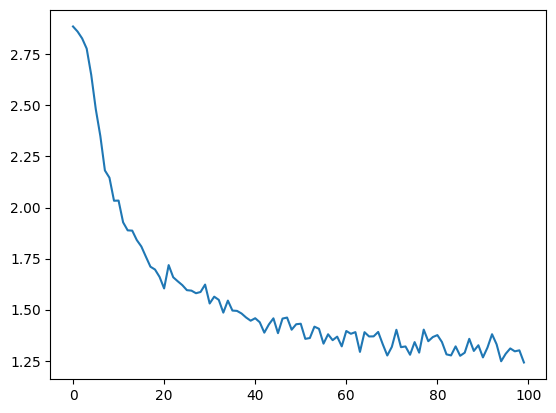

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/var/folders/62/sqk699ld69v13ny7hdx8n4980000gn/T/ipykernel_45518/2887250372.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + all_categories, rotation=90)
/var/folders/62/sqk699ld69v13ny7hdx8n4980000gn/T/ipykernel_45518/2887250372.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + all_categories)


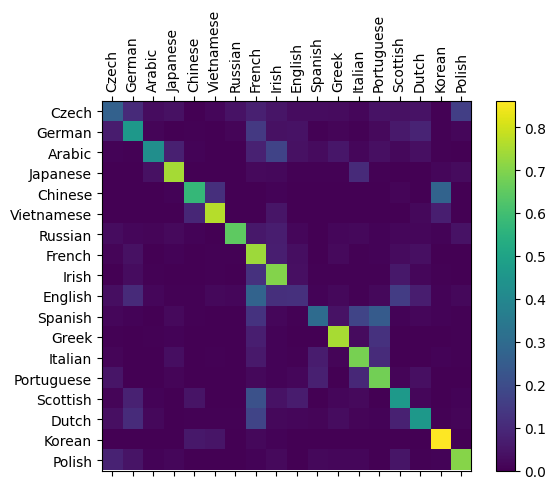

In [16]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000


# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output


# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([""] + all_categories, rotation=90)
ax.set_yticklabels([""] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [17]:
def predict(input_line, n_predictions=3):
    print("\n> %s" % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print("(%.2f) %s" % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


predict("Dovesky")
predict("Jackson")
predict("Satoshi")


> Dovesky
(-1.08) Russian
(-1.23) Czech
(-1.43) English

> Jackson
(-0.07) Scottish
(-3.17) English
(-4.85) French

> Satoshi
(-0.76) Polish
(-1.54) Italian
(-2.25) Japanese


In [18]:
predict("Deependu")
predict("Nepali")


> Deependu
(-0.31) French
(-2.09) German
(-3.34) Italian

> Nepali
(-0.23) Italian
(-3.32) Polish
(-3.62) English


## Save model

In [19]:
import torch

torch.save(rnn, "rnn.pth")
torch.save(rnn.state_dict(), "rnn_state_dict.pth")

---

## load model

In [20]:
import torch

my_loaded_rnn_model = torch.load("rnn.pth")

my_loaded_rnn_model

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [21]:
my_loaded_rnn_model_with_state_dict = torch.load("rnn_state_dict.pth")

In [22]:
my_loaded_rnn_model_with_state_dict

OrderedDict([('i2h.weight',
              tensor([[-0.0293, -0.1356,  0.2930,  ..., -0.1210, -0.0148,  0.0188],
                      [-0.2580, -0.0126,  0.0166,  ...,  0.0535,  0.0440,  0.0021],
                      [-0.0796,  0.0500,  0.0506,  ..., -0.0912,  0.0271,  0.0462],
                      ...,
                      [ 0.1602,  0.2037,  0.1519,  ..., -0.0589,  0.0469,  0.0336],
                      [-0.3357, -0.0432,  0.0469,  ...,  0.0241,  0.1287,  0.0090],
                      [-0.0451,  0.1101, -0.0739,  ...,  0.1146,  0.0233, -0.0291]])),
             ('i2h.bias',
              tensor([ 0.0274,  0.0850,  0.0385, -0.1175, -0.0066, -0.0074,  0.0256,  0.0096,
                      -0.0360,  0.0025, -0.0934,  0.0164, -0.0461, -0.0335, -0.0150, -0.1399,
                      -0.0204, -0.0533,  0.1301,  0.0094,  0.0285, -0.1256,  0.0177,  0.0701,
                       0.1003, -0.0665,  0.0221, -0.1124,  0.0948,  0.0717,  0.0391,  0.0361,
                      -0.0374, -0.07

In [23]:
all_losses[:5]

[2.8859749393463137,
 2.861133049726486,
 2.8275869324207306,
 2.777683599948883,
 2.6489026036672296]